# Deep inside: Autoencoders

This notebook is the complement of [this blog post](https://towardsdatascience.com/deep-inside-autoencoders-7e41f319999f)

4 types of autoencoders are described using the Keras framework and the MNIST dataset

1. Vanilla autoencoders
2. Multilayer autoencoder
3. Convolutional autoencoder
4. Regularized autoencoder

## Import the libraries

In [ ]:
pip install keras

In [2]:
import keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


from keras.datasets import mnist
from keras.models import Model
from tensorflow.keras.layers import Input, add
from keras.layers import Layer, Dense, Dropout, Activation, Flatten, Reshape
from keras import regularizers
from keras.regularizers import l2
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.utils import np_utils

## Load the data

We don't need the labels as the autoencoders are unsupervised network

In [3]:
(X_train, _), (X_test, _) = mnist.load_data()

# X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
# X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

In [4]:
X_train.shape

(60000, 28, 28)

## Normalize the data

We want the pixels values between 0 and 1 instead of between 0 and 255

In [5]:
X_train = X_train.astype("float32")/255.
X_test = X_test.astype("float32")/255.

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (60000, 28, 28)
60000 train samples
10000 test samples


## Flatten the images for the Fully-Connected Networks

In [6]:
X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))

In [7]:
print(X_train.shape)

(60000, 784)


In [8]:
print(X_test.shape)

(10000, 784)


___

# **Vanilla Autoencoder**

### Create the network

The first network is the most simple autoencoder. It has three layers : Input - encoded - decoded

In [7]:
input_size = 784
hidden_size = 64
output_size = 784

In [8]:
x = Input(shape=(input_size,))
h = Dense(hidden_size, activation='relu')(x)
r = Dense(output_size, activation='sigmoid')(h)

autoencoder = Model(inputs=x, outputs=r)
autoencoder.compile(optimizer='adam', loss='mse')

In [11]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 64)                50240     
                                                                 
 dense_1 (Dense)             (None, 784)               50960     
                                                                 
Total params: 101,200
Trainable params: 101,200
Non-trainable params: 0
_________________________________________________________________


### Train

In [9]:
epochs = 5
batch_size = 128

history = autoencoder.fit(X_train, X_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test, X_test))

Epoch 1/5
469/469 [==============================] - 2s 3ms/step - loss: 0.0443 - val_loss: 0.0220
Epoch 2/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0170 - val_loss: 0.0129
Epoch 3/5
469/469 [==============================] - 1s 3ms/step - loss: 0.0108 - val_loss: 0.0088
Epoch 4/5
469/469 [==============================] - 1s 3ms/step - loss: 0.0078 - val_loss: 0.0067
Epoch 5/5
469/469 [==============================] - 1s 3ms/step - loss: 0.0062 - val_loss: 0.0055


313/313 [==============================] - 0s 537us/step


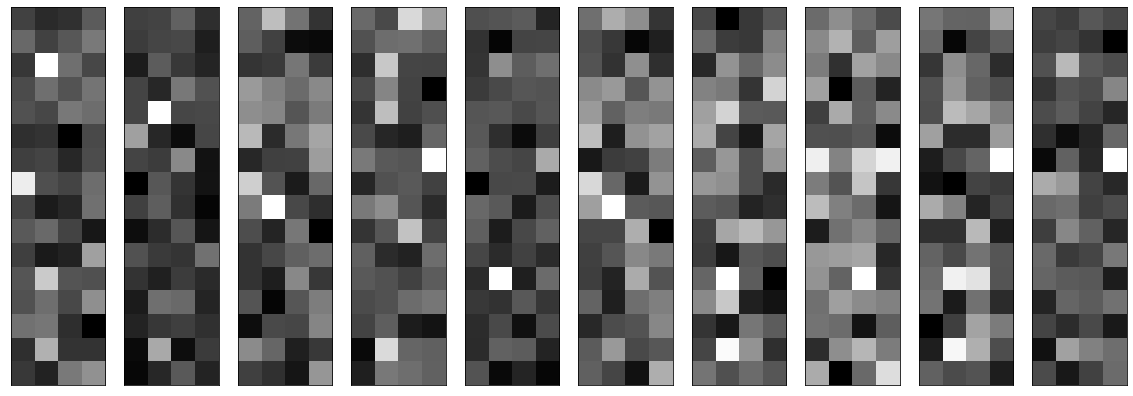

In [13]:
conv_encoder = Model(x, h)
encoded_imgs = conv_encoder.predict(X_test)

n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(encoded_imgs[i].reshape(4, 16).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Predict on the test set

In [10]:
decoded_imgs = autoencoder.predict(X_test)

313/313 [==============================] - 0s 865us/step


### Plot

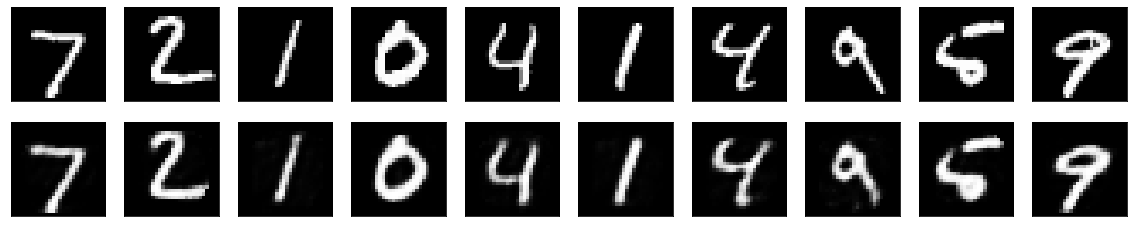

In [15]:
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i+1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # display reconstruction
    ax = plt.subplot(3, n, i+n+1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Plot the losses

dict_keys(['loss', 'val_loss'])


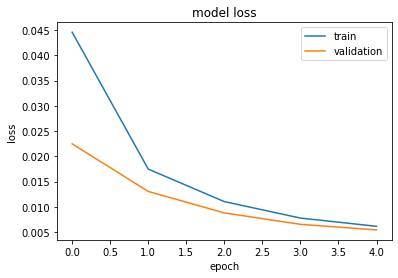

In [16]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

---

# **Multilayer autoencoder**

### Create the network

We extend the idea of the first network to more layers

In [17]:
input_size = 784
hidden_size = 128
code_size = 64

x = Input(shape=(input_size,))
hidden_1 = Dense(hidden_size, activation='relu')(x)
h = Dense(code_size, activation='relu')(hidden_1)
hidden_2 = Dense(hidden_size, activation='relu')(h)
r = Dense(input_size, activation='sigmoid')(hidden_2)

autoencoder = Model(inputs=x, outputs=r)
autoencoder.compile(optimizer='adam', loss='mse')

In [18]:
!pip install pydot

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(autoencoder).create(prog='dot', format='svg'))

In [19]:
from keras.utils import plot_model
plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


### Train the network

In [21]:
epochs = 5
batch_size = 128

history = autoencoder.fit(X_train, X_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test, X_test))

Epoch 1/5


469/469 [==============================] - 2s 3ms/step - loss: 0.0415 - val_loss: 0.0193
Epoch 2/5
469/469 [==============================] - 2s 3ms/step - loss: 0.0154 - val_loss: 0.0124
Epoch 3/5
469/469 [==============================] - 2s 3ms/step - loss: 0.0114 - val_loss: 0.0100
Epoch 4/5
469/469 [==============================] - 2s 3ms/step - loss: 0.0097 - val_loss: 0.0088
Epoch 5/5
469/469 [==============================] - 2s 3ms/step - loss: 0.0087 - val_loss: 0.0080


### Predict on the test set

In [22]:
decoded_imgs = autoencoder.predict(X_test)

313/313 [==============================] - 0s 1ms/step


### Plot

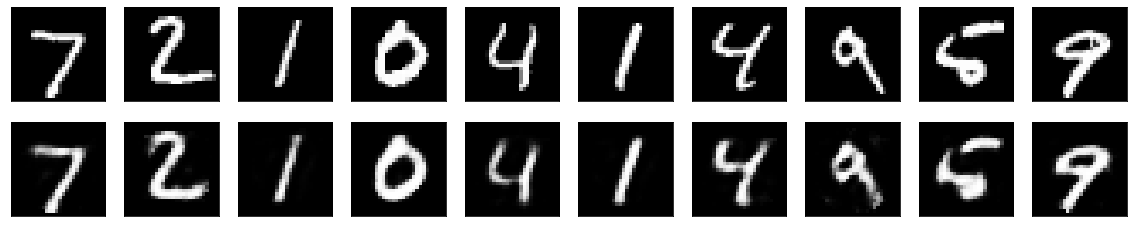

In [23]:
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i+1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    
    # display reconstruction
    ax = plt.subplot(3, n, i+n+1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

### Plot the losses

dict_keys(['loss', 'val_loss'])


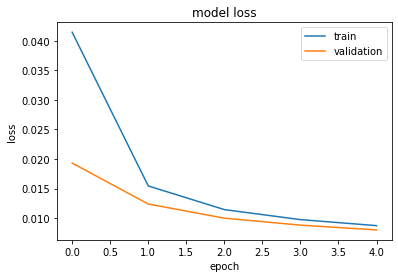

In [24]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

___

# **Convolutional autoencoder**

In [25]:
nb_classes = 10

(X_train, y_train), (X_test, y_test) = mnist.load_data()

# # X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
# # X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
X_train = X_train.astype("float32")/255.
X_test = X_test.astype("float32")/255.
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# y_train = np_utils.to_categorical(y_train, nb_classes)
# y_test = np_utils.to_categorical(y_test, nb_classes)

X_train shape: (60000, 28, 28)
60000 train samples
10000 test samples


### Create the network

This network does not take flattened vectors as an input but images

In [26]:
x = Input(shape=(28, 28,1)) 

# Encoder
conv1_1 = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
pool1 = MaxPooling2D((2, 2), padding='same')(conv1_1)
conv1_2 = Conv2D(8, (3, 3), activation='relu', padding='same')(pool1)
pool2 = MaxPooling2D((2, 2), padding='same')(conv1_2)
conv1_3 = Conv2D(8, (3, 3), activation='relu', padding='same')(pool2)
h = MaxPooling2D((2, 2), padding='same')(conv1_3)

# Decoder
conv2_1 = Conv2D(8, (3, 3), activation='relu', padding='same')(h)
up1 = UpSampling2D((2, 2))(conv2_1)
conv2_2 = Conv2D(8, (3, 3), activation='relu', padding='same')(up1)
up2 = UpSampling2D((2, 2))(conv2_2)
conv2_3 = Conv2D(16, (3, 3), activation='relu')(up2)
up3 = UpSampling2D((2, 2))(conv2_3)
r = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up3)

autoencoder = Model(inputs=x, outputs=r)
autoencoder.compile(optimizer='adadelta', loss='mse')

### Train

In [28]:
epochs = 3
batch_size = 128

history = autoencoder.fit(X_train, X_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test, X_test))

Epoch 1/3


469/469 [==============================] - 45s 96ms/step - loss: 0.2305 - val_loss: 0.2303
Epoch 2/3
469/469 [==============================] - 45s 96ms/step - loss: 0.2298 - val_loss: 0.2295
Epoch 3/3
469/469 [==============================] - 46s 97ms/step - loss: 0.2289 - val_loss: 0.2284


In [29]:
decoded_imgs = autoencoder.predict(X_test)

313/313 [==============================] - 2s 6ms/step


### Plot

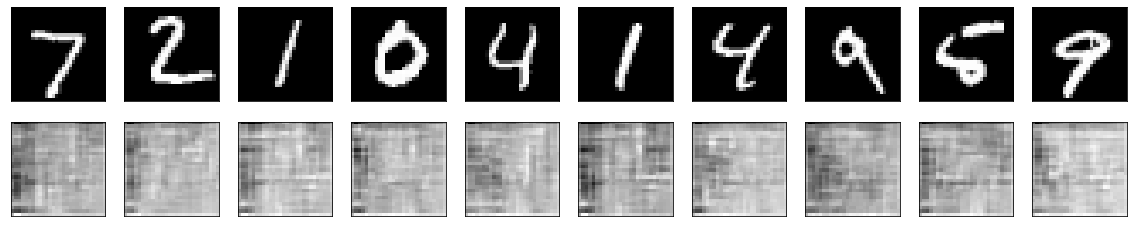

In [30]:
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i+1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    
    # display reconstruction
    ax = plt.subplot(3, n, i+n+1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

### Plot the losses

dict_keys(['loss', 'val_loss'])


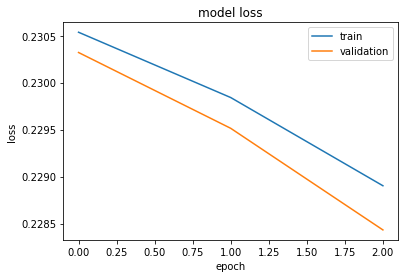

In [31]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

Denoising encoder


In [4]:
(X_train, _), (X_test, _) = mnist.load_data()

# X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
# X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

In [5]:
X_train = X_train.astype("float32")/255.
X_test = X_test.astype("float32")/255.

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (60000, 28, 28)
60000 train samples
10000 test samples


In [6]:
X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))

In [12]:
x_train=X_train

In [13]:
x_test=X_test

In [18]:
corruption_level = 0.3

x_train_noisy = x_train + corruption_level * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + corruption_level * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
print(x_train_noisy.shape)
print(x_test_noisy.shape)


# Hyper parameters
batch_size = 128
nb_epoch = 5

# Parameters for MNIST dataset
img_rows, img_cols = 28, 28

# Parameters for denoising autoencoder
nb_visible = img_rows * img_cols
nb_hidden = 32

# Build autoencoder model
input_img = Input(shape=(nb_visible,))
encoded = Dense(nb_hidden, activation='relu')(input_img)
decoded = Dense(nb_visible, activation='sigmoid')(encoded)

autoencoder = Model(inputs=input_img, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()





(60000, 784)
(10000, 784)
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_6 (Dense)             (None, 32)                25120     
                                                                 
 dense_7 (Dense)             (None, 784)               25872     
                                                                 
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


In [17]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=nb_epoch, batch_size=batch_size, shuffle=True, verbose=1,
                validation_data=(x_test_noisy, x_test))

Epoch 1/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0556 - val_loss: 0.0335
Epoch 2/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0281 - val_loss: 0.0232
Epoch 3/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0211 - val_loss: 0.0187
Epoch 4/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0179 - val_loss: 0.0166
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0164 - val_loss: 0.0155
